# Exploration - "Brute Force" Approach

Exploring the problem "head on" before we optimize. There are two elements we need to track, tendered CCY and any change received. 

Let's begin by getting a list of all valid combinations and associated change.

Brute force exploration surfaced the following pointers:
* `itertools.combinations` proved useful
* Viable combinations formed a bell curve and seemed manageable
* Use `Decimal` to handle floating point precision issues

Follow Up Questions:

1) When the total lengths are equal is one solution preferable?

    - Option `(1)` - Pay 3 units / Receive 5 units
    - Option `(2)` - Pay 8 units / Receive 0 units
    
   The option `(2)` is more expensive to compute. For performance, I might opt not to search to find the latter if option `(1)` is equivalent & sufficient

Although Brute force works, performance gets exponentially worse past a certain point (~14 items).

Ideas:
* Memoization might help
* BFS tree might help (worried about being too wide)

In [ ]:
import pandas as pd
import numpy as np
import math
import logging

from agora.helpers import populate_wallet, get_total, find_viable_combinations, calculate_change
from decimal import Decimal
from itertools import combinations

import matplotlib.pyplot as plt
from tqdm import tqdm

from agora.ref_data import DECIMALIZED_DENOMINATIONS_USD

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [2]:
# Log messages
logger.info("This is an info log.")
logger.debug("This is a debug log.")
logger.warning("This is a warning log.")
logger.error("This is an error log.")
logger.critical("This is a critical log.")

INFO: This is an info log.
ERROR: This is an error log.
CRITICAL: This is a critical log.


In [3]:
# inputs
price: Decimal = Decimal("15.05")

money: dict[str, int] = {
    "100": 1,
    "20": 4,
    "10": 2,
    "1": 5,
    "0.25": 1,
    "0.10": 6,
    "0.05": 3,
    # "0.01": 5,  # <|--- explodes the problem
}

# setup wallet
wallet = populate_wallet(money)

# initialize variables
best_combination = (wallet, calculate_change(get_total(wallet) - price))
best_length: int = len(wallet) + len(calculate_change(get_total(wallet) - price))

In [4]:
print(f"Money in wallet - ${get_total(wallet)}")

Money in wallet - $206.00


In [5]:
# Classic floating point precision
0.1 + 0.2

0.30000000000000004

In [6]:
# Check wallet for all viable combinations
num_picks = 8
len([sum(combo) for combo in find_viable_combinations(wallet, num_picks, price)])

733

In [7]:
# Here is the big problem if we aren't thoughtful -- huge search space!
math.factorial(len(wallet))

1124000727777607680000

In [8]:
# Observation: As the number of combinations increases, the number of viable combinations decreases -- didn't see that coming!
plot_values = []

for i in tqdm(range(1, len(wallet) + 1), desc="Processing combinations", ncols=100):
    plot_values.append(len(find_viable_combinations(wallet, i, price)))

Processing combinations: 100%|██████████████████████████████████████| 22/22 [00:02<00:00,  7.95it/s]


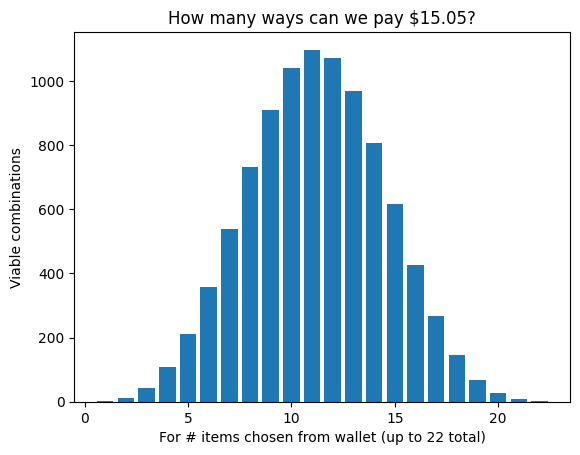

In [9]:
# Plot search space
plt.bar(range(1, len(plot_values) + 1), plot_values)
plt.xlabel(f"For # items chosen from wallet (up to {len(plot_values)} total)")
plt.ylabel("Viable combinations")
plt.title(f"How many ways can we pay ${price}?")
plt.show()

In [10]:
if get_total(wallet) > price:
    print("You have enough money to buy the item.")

print(f"Size of wallet: {len(wallet)}")

You have enough money to buy the item.
Size of wallet: 22


In [11]:
math.comb(len(wallet), 3)

1540

In [12]:
# Generate all combinations of a specific length (e.g., )
comb_length = 2
combinations_list = set(sorted(combinations(wallet, comb_length)))

print(f"Number of combinations of length {comb_length}: {len(combinations_list)}")
print(combinations_list)

Number of combinations of length 2: 26
{(Decimal('100'), Decimal('10')), (Decimal('20'), Decimal('20')), (Decimal('10'), Decimal('0.25')), (Decimal('1'), Decimal('0.25')), (Decimal('0.25'), Decimal('0.05')), (Decimal('10'), Decimal('0.05')), (Decimal('1'), Decimal('0.05')), (Decimal('20'), Decimal('1')), (Decimal('0.25'), Decimal('0.10')), (Decimal('100'), Decimal('0.25')), (Decimal('20'), Decimal('10')), (Decimal('0.10'), Decimal('0.05')), (Decimal('10'), Decimal('0.10')), (Decimal('1'), Decimal('0.10')), (Decimal('100'), Decimal('0.05')), (Decimal('0.10'), Decimal('0.10')), (Decimal('100'), Decimal('0.10')), (Decimal('20'), Decimal('0.25')), (Decimal('0.05'), Decimal('0.05')), (Decimal('20'), Decimal('0.05')), (Decimal('100'), Decimal('20')), (Decimal('1'), Decimal('1')), (Decimal('10'), Decimal('1')), (Decimal('10'), Decimal('10')), (Decimal('20'), Decimal('0.10')), (Decimal('100'), Decimal('1'))}


In [13]:
get_total(wallet)

Decimal('206.00')

In [14]:
calculate_change(Decimal("5.05"))

[Decimal('0.05'), Decimal('5.00')]

In [15]:
for picks in range(1, len(wallet) + 1):

    logger.debug(f"Trying combinations of {picks} item(s) from wallet")

    for combination in find_viable_combinations(wallet, 2, price):

        change = calculate_change(get_total(combination) - price)
        ccy_exchanged = len(combination) + len(change)

        if ccy_exchanged < best_length:
            best_combination = (combination, change)
            best_length = ccy_exchanged

    if best_length <= picks:
        logger.info(
            f"Stopped early - Best combination found"
        )
        break

INFO: Stopped early - Best combination found


In [16]:
best_length

3

In [17]:
best_combination

((Decimal('20'), Decimal('0.05')), [Decimal('5.00')])